# Basic Setup

In [1]:
# check if GPU has been used
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Aug  1 14:14:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# check if High-RAM has been used
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# from google.colab import drive

# drive.flush_and_unmount()


In [4]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# DATA_DIR = '/content/drive/My Drive/Datasets/NIH_chest_xray/NIH_chest_xray_image'
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')
DATA_DIR = "/content/gdrive/My Drive/w210_capstone/balance_set_age_local/"
image_size = 224
batch_size = 32

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
df = pd.read_csv("/content/gdrive/My Drive/w210_capstone/Balance_set_age/balance_age.csv", sep='\t')
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, '*', '*.png'))}
df['path'] = df.idx.map(data_image_paths.get)
df.disease = df.disease.map(lambda x: x.replace('No Finding', 'Normal'))
df = df.dropna(axis=0)
labels = np.unique(df.disease.tolist())
labels = [x for x in labels if len(x) > 0]

In [6]:
df = df[[i not in ['Normal'] for i in df.disease]]
labels = np.unique(df.disease.tolist())
labels = [x for x in labels if len(x) > 0]


In [7]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Effusion',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening']

### replace all disease labels with "Disease"

In [39]:
df_2tier = df.copy()
for i in labels:
  df_2tier.disease = df_2tier.disease.map(lambda x: x.replace(i, 'Disease'))
df_2tier = df_2tier[['idx','disease','followup','gender','position','age','path']]
df_2tier.head()

,idx,disease,followup,gender,position,age,path
0,00000001_000.png,Disease,0,M,PA,58,/content/gdrive/My Drive/w210_capstone/balance...
1,00000005_006.png,Disease,6,F,PA,70,/content/gdrive/My Drive/w210_capstone/balance...
2,00000008_000.png,Disease,0,F,PA,69,/content/gdrive/My Drive/w210_capstone/balance...
3,00000013_003.png,Disease,3,M,AP,60,/content/gdrive/My Drive/w210_capstone/balance...
4,00000013_009.png,Disease,9,M,AP,60,/content/gdrive/My Drive/w210_capstone/balance...


In [40]:
for label in ['Normal','Disease']:
    if len(label) > 1:
        df_2tier[label] = df_2tier.disease.map(lambda finding: 1.0 if label in finding else 0.0)
df_2tier.head()

,idx,disease,followup,gender,position,age,path,Normal,Disease
0,00000001_000.png,Disease,0,M,PA,58,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
1,00000005_006.png,Disease,6,F,PA,70,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
2,00000008_000.png,Disease,0,F,PA,69,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
3,00000013_003.png,Disease,3,M,AP,60,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
4,00000013_009.png,Disease,9,M,AP,60,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0


### for binary model

#### make new path list for normal images to adjust class balances

In [10]:
df_normal = pd.read_csv("/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/Data_Entry_2017.csv")
df_normal = df_normal[df_normal['Finding Labels'] == 'No Finding']
df_normal = df_normal[(df_normal['Patient Age'] >= 20) & (df_normal['Patient Age'] < 70)]
df_normal = df_normal[df_normal['Follow-up #'] == 0]
df_normal = df_normal[['Image Index', 'Finding Labels', 
       'Patient Age', 'Patient Gender', 'View Position']]
       
df_normal.columns = ['idx','disease','age','gender','position']

df_normal.head()

,idx,disease,age,gender,position
13,00000005_000.png,No Finding,69,F,PA
38,00000013_000.png,No Finding,61,M,PA
85,00000014_000.png,No Finding,61,F,PA
98,00000022_000.png,No Finding,48,M,PA
100,00000023_000.png,No Finding,63,F,PA


In [11]:
DATA_DIR_normal = "/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/"
# data_image_paths_normal = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR_normal, '*', '*.png'))}
# df_normal['path'] = df_normal.idx.map(data_image_paths_normal.get)
# df_normal.disease = df_normal.disease.map(lambda x: x.replace('No Finding', 'Normal'))

In [14]:
# df_normal.head()

,idx,disease,age,gender,position
13,00000005_000.png,No Finding,69,F,PA
38,00000013_000.png,No Finding,61,M,PA
85,00000014_000.png,No Finding,61,F,PA
98,00000022_000.png,No Finding,48,M,PA
100,00000023_000.png,No Finding,63,F,PA


In [30]:
list_norm_images = os.listdir(DATA_DIR_normal)
list_norm_images

['00029464_012.png',
 '00029464_008.png',
 '00029464_013.png',
 '00029469_002.png',
 '00029469_016.png',
 '00029469_006.png',
 '00029469_014.png',
 '00029470_002.png',
 '00029470_001.png',
 '00029470_003.png',
 '00029470_006.png',
 '00029470_007.png',
 '00029470_008.png',
 '00029470_013.png',
 '00029470_017.png',
 '00029474_006.png',
 '00029474_003.png',
 '00029474_001.png',
 '00029478_001.png',
 '00029474_008.png',
 '00029479_002.png',
 '00029479_004.png',
 '00029479_007.png',
 '00029479_005.png',
 '00029481_010.png',
 '00029503_002.png',
 '00029503_001.png',
 '00029503_004.png',
 '00029504_000.png',
 '00029513_000.png',
 '00029513_001.png',
 '00029511_001.png',
 '00029513_003.png',
 '00029516_000.png',
 '00029530_001.png',
 '00029532_000.png',
 '00029532_012.png',
 '00029537_001.png',
 '00029535_000.png',
 '00029537_002.png',
 '00029551_001.png',
 '00029548_010.png',
 '00029551_002.png',
 '00029572_002.png',
 '00029579_006.png',
 '00029579_010.png',
 '00029579_013.png',
 '00029587_00

In [31]:
list_norm_path = [DATA_DIR_normal+i for i in list_norm_images]
list_norm_path

['/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029464_012.png',
 '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029464_008.png',
 '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029464_013.png',
 '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029469_002.png',
 '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029469_016.png',
 '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029469_006.png',
 '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029469_014.png',
 '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029470_002.png',
 '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029470_001.png',
 '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_c

In [32]:
dict_norm = dict(zip(list_norm_images, list_norm_path))
dict_norm

{'00029464_012.png': '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029464_012.png',
 '00029464_008.png': '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029464_008.png',
 '00029464_013.png': '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029464_013.png',
 '00029469_002.png': '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029469_002.png',
 '00029469_016.png': '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029469_016.png',
 '00029469_006.png': '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029469_006.png',
 '00029469_014.png': '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029469_014.png',
 '00029470_002.png': '/content/gdrive/My Drive/w210_capstone/Datasets/NIH_chest_xray/NIH_chest_xray_image/00029470_002.png',


In [33]:
df_normal['path'] = df_normal.idx.map(dict_norm.get)

In [34]:
df_normal.head()

,idx,disease,age,gender,position,path
13,00000005_000.png,No Finding,69,F,PA,/content/gdrive/My Drive/w210_capstone/Dataset...
38,00000013_000.png,No Finding,61,M,PA,/content/gdrive/My Drive/w210_capstone/Dataset...
85,00000014_000.png,No Finding,61,F,PA,/content/gdrive/My Drive/w210_capstone/Dataset...
98,00000022_000.png,No Finding,48,M,PA,/content/gdrive/My Drive/w210_capstone/Dataset...
100,00000023_000.png,No Finding,63,F,PA,/content/gdrive/My Drive/w210_capstone/Dataset...


In [35]:
df_normal.isna().sum()

idx         0
disease     0
age         0
gender      0
position    0
path        0
dtype: int64

In [36]:
df_normal_sample = df_normal.sample(n=10000, random_state=102)
df_normal_sample.shape

(10000, 6)

In [37]:
df_normal_sample['followup'] = 0
df_normal_sample.head()

,idx,disease,age,gender,position,path,followup
16159,00004328_000.png,No Finding,59,M,AP,/content/gdrive/My Drive/w210_capstone/Dataset...,0
36662,00009653_000.png,No Finding,42,F,PA,/content/gdrive/My Drive/w210_capstone/Dataset...,0
102292,00027232_000.png,No Finding,22,F,PA,/content/gdrive/My Drive/w210_capstone/Dataset...,0
46436,00011865_000.png,No Finding,40,M,PA,/content/gdrive/My Drive/w210_capstone/Dataset...,0
3837,00001049_000.png,No Finding,27,M,PA,/content/gdrive/My Drive/w210_capstone/Dataset...,0


In [38]:
df_normal_sample['Normal'] = 1
df_normal_sample['Disease'] = 0
df_normal_sample = df_normal_sample[['idx', 'disease', 'followup', 'gender', 'position', 'age', 'path',
       'Normal', 'Disease']]
df_normal_sample.head()

,idx,disease,followup,gender,position,age,path,Normal,Disease
16159,00004328_000.png,No Finding,0,M,AP,59,/content/gdrive/My Drive/w210_capstone/Dataset...,1,0
36662,00009653_000.png,No Finding,0,F,PA,42,/content/gdrive/My Drive/w210_capstone/Dataset...,1,0
102292,00027232_000.png,No Finding,0,F,PA,22,/content/gdrive/My Drive/w210_capstone/Dataset...,1,0
46436,00011865_000.png,No Finding,0,M,PA,40,/content/gdrive/My Drive/w210_capstone/Dataset...,1,0
3837,00001049_000.png,No Finding,0,M,PA,27,/content/gdrive/My Drive/w210_capstone/Dataset...,1,0


In [34]:
# df_normal_sample.to_csv('/content/gdrive/My Drive/w210_capstone/normal_list.csv')

In [12]:
# df_normal_sample = pd.read_csv('/content/gdrive/My Drive/w210_capstone/normal_list.csv')

In [41]:
df_2tier.head()

,idx,disease,followup,gender,position,age,path,Normal,Disease
0,00000001_000.png,Disease,0,M,PA,58,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
1,00000005_006.png,Disease,6,F,PA,70,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
2,00000008_000.png,Disease,0,F,PA,69,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
3,00000013_003.png,Disease,3,M,AP,60,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
4,00000013_009.png,Disease,9,M,AP,60,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0


In [42]:
df_2tier = df_2tier[df_2tier.Disease == 1]
# df_2tier.head(60)

In [43]:
df_2tier_comb = df_2tier.append(df_normal_sample)
df_2tier_comb.shape

(22958, 9)

In [44]:
df_2tier_comb.head()

,idx,disease,followup,gender,position,age,path,Normal,Disease
0,00000001_000.png,Disease,0,M,PA,58,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
1,00000005_006.png,Disease,6,F,PA,70,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
2,00000008_000.png,Disease,0,F,PA,69,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
3,00000013_003.png,Disease,3,M,AP,60,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
4,00000013_009.png,Disease,9,M,AP,60,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0


In [45]:
df_2tier_comb = df_2tier_comb.sample(frac=0.5).reset_index(drop=True)
df_2tier_comb.head()

,idx,disease,followup,gender,position,age,path,Normal,Disease
0,00014145_023.png,Disease,23,M,AP,55,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
1,00002756_001.png,Disease,1,M,PA,65,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
2,00006631_000.png,No Finding,0,F,PA,48,/content/gdrive/My Drive/w210_capstone/Dataset...,1.0,0.0
3,00020037_009.png,Disease,9,M,AP,45,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
4,00000798_026.png,Disease,26,F,AP,65,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0


In [46]:
df_2tier_comb.disease = df_2tier_comb.disease.map(lambda x: x.replace('No Finding', 'Normal'))


In [48]:
df_2tier_comb.head(30)

,idx,disease,followup,gender,position,age,path,Normal,Disease
0,00014145_023.png,Disease,23,M,AP,55,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
1,00002756_001.png,Disease,1,M,PA,65,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
2,00006631_000.png,Normal,0,F,PA,48,/content/gdrive/My Drive/w210_capstone/Dataset...,1.0,0.0
3,00020037_009.png,Disease,9,M,AP,45,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
4,00000798_026.png,Disease,26,F,AP,65,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
5,00001202_001.png,Disease,1,F,PA,46,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
6,00013714_009.png,Disease,9,M,PA,35,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
7,00024427_000.png,Normal,0,M,PA,30,/content/gdrive/My Drive/w210_capstone/Dataset...,1.0,0.0
8,00006850_015.png,Disease,15,M,AP,57,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0
9,00011121_005.png,Disease,5,F,AP,47,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0


#### prepare train test

In [49]:
train_binary_df, valid_binary_df = train_test_split(df_2tier_comb, test_size=0.20, random_state=2018)

In [50]:
train_binary_df['labels'] = train_binary_df.apply(lambda x: x['disease'], axis=1)
valid_binary_df['labels'] = valid_binary_df.apply(lambda x: x['disease'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
train_binary_df.disease.value_counts()

Disease    5172
Normal     4011
Name: disease, dtype: int64

In [52]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
class_weight_list = class_weight.compute_class_weight('balanced', np.unique(train_binary_df.disease.tolist()), train_binary_df.disease.tolist())
class_weight_dict = {i: class_weight_list[i] for i in range(0, len(class_weight_list))}
class_weight_dict

{0: 0.8877610208816705, 1: 1.144727000747943}

In [53]:
np.unique(train_binary_df.disease.tolist())

array(['Disease', 'Normal'], dtype='<U7')

In [54]:
valid_binary_df.disease.value_counts()

Disease    1306
Normal      990
Name: disease, dtype: int64

In [55]:
valid_binary_df.head()

,idx,disease,followup,gender,position,age,path,Normal,Disease,labels
5495,00010790_019.png,Disease,19,F,AP,56,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0,Disease
5911,00012007_000.png,Normal,0,M,PA,55,/content/gdrive/My Drive/w210_capstone/Dataset...,1.0,0.0,Normal
9178,00016414_002.png,Disease,2,M,PA,39,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0,Disease
10325,00007295_000.png,Normal,0,M,PA,37,/content/gdrive/My Drive/w210_capstone/Dataset...,1.0,0.0,Normal
5804,00006338_003.png,Disease,3,F,AP,53,/content/gdrive/My Drive/w210_capstone/balance...,0.0,1.0,Disease


In [56]:
labels_binary = ['Normal','Disease']

In [57]:
%%time
core_idg_binary = ImageDataGenerator(rescale=1 / 255,
                                  # samplewise_center=True,
                                  # samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.05,
                                  width_shift_range=0.1,
                                  rotation_range=2.5,
                                  shear_range=0.1,
                                  fill_mode='reflect',
                                  zoom_range=0.15)

train_gen_binary = core_idg_binary.flow_from_dataframe(dataframe=train_binary_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels_binary,
                                             target_size=(image_size, image_size))

# valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
#                                              directory=None,
#                                              x_col='path',
#                                              y_col='labels',
#                                              class_mode='categorical',
#                                              batch_size=batch_size,
#                                              classes=labels,
#                                              target_size=(image_size, image_size))

test_X_binary, test_Y_binary = next(core_idg_binary.flow_from_dataframe(dataframe=valid_binary_df,
                                                       directory=None,
                                                       x_col='path',
                                                       y_col='labels',
                                                       class_mode='categorical',
                                                       batch_size=1024,
                                                       classes=labels_binary,
                                                       target_size=(image_size, image_size)))

Found 9183 validated image filenames belonging to 2 classes.
Found 2296 validated image filenames belonging to 2 classes.
CPU times: user 25.3 s, sys: 1.94 s, total: 27.2 s
Wall time: 12min 56s


In [58]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import Model, Input
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers


# Load the TensorBoard notebook extension.
%load_ext tensorboard

from datetime import datetime
from packaging import version

import tensorflow as tf
import numpy as np

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):

  def __init__(self, savepath):
    super(MetricsCheckpoint, self).__init__()
    self.savepath = savepath
    self.history = {}
      
  def on_epoch_end(self, epoch, logs=None):
    for k, v in logs.items():
        self.history.setdefault(k, []).append(v)
    np.save(self.savepath, self.history)


def plotkerasLearningCurve():
  plt.figure(figsize=(10, 5))
  metrics = np.load('logs.npy', allow_pickle=True)[()]
  filt = ['acc'] # see 'loss'
  for k in filter(lambda x: np.any([kk in x for kk in filt]), metrics.keys()):
    l = np.array(metrics[k])
    plt.plot(l, c='r' if 'val' not in k else 'b', label = 'val' if 'val' in k else 'train')
    x = np.argmin(l) if 'loss' in k else np.argmax(l)
    y = l[x]
    plt.scatter(x, y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
    plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color='r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None])
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

import itertools

def plotConfusionMatrix(cm, classes, normalize = False, title = 'Confusion Matrix', cmap = plt.cm.Blues):
  plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title = title
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without nomralization")
  
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


def plotLearningCurve(history):
  plt.figure(figsize=(8, 8))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  # plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('./accuracy_curve.png')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  # plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig('./loss_curve.png')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TensorFlow version:  2.2.0


#### train all layers

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

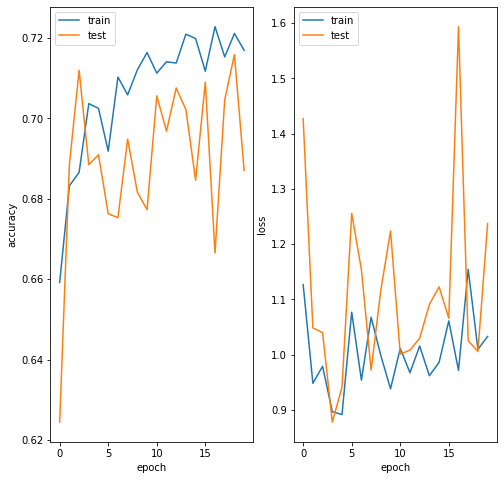

Epoch 1/50
287/287 [==============================] - ETA: 0s - loss: 2.0850 - binary_accuracy: 0.6544 - auc: 0.6998
Epoch 00001: loss improved from inf to 2.08503, saving model to /content/gdrive/My Drive/w210_capstone/balance_age_model/model_7p2_retrain/model_7_retrain.h5
287/287 [==============================] - 309s 1s/step - loss: 2.0850 - binary_accuracy: 0.6544 - auc: 0.6998 - val_loss: 1.7825 - val_binary_accuracy: 0.6479 - val_auc: 0.7020
Epoch 2/50
287/287 [==============================] - ETA: 0s - loss: 1.4240 - binary_accuracy: 0.6809 - auc: 0.7399
Epoch 00002: loss improved from 2.08503 to 1.42399, saving model to /content/gdrive/My Drive/w210_capstone/balance_age_model/model_7p2_retrain/model_7_retrain.h5
287/287 [==============================] - 308s 1s/step - loss: 1.4240 - binary_accuracy: 0.6809 - auc: 0.7399 - val_loss: 1.3666 - val_binary_accuracy: 0.6318 - val_auc: 0.6855
Epoch 3/50
287/287 [==============================] - ETA: 0s - loss: 1.0753 - binary_accu

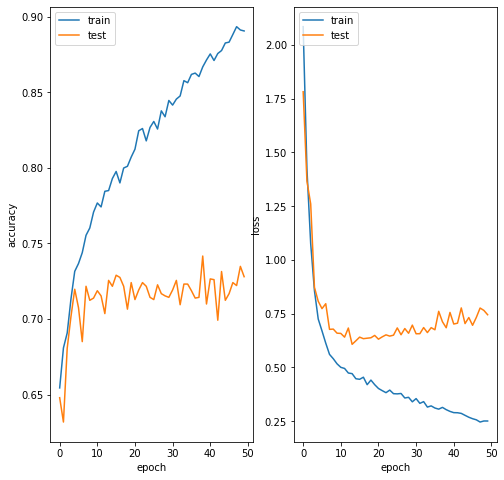

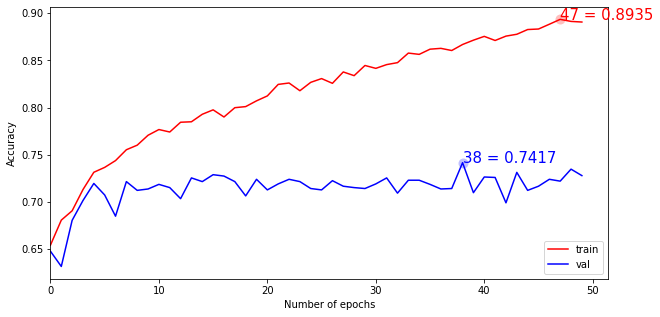

In [53]:
# https://keras.io/api/applications/ fine tune pretrained model

from tensorflow.keras.applications import DenseNet121
# pretrain_model_densenet121 = DenseNet121(weights = 'imagenet', include_top = False, input_shape=(img_size, img_size, 3))

# new_model, model_history = pretrainedNetwork(train_ds, valid_ds, pretrain_model_densenet121, class_weight_dict, 17, 50, optimizer_adam, map_dict)
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(len(labels_binary), activation="sigmoid")(x)
model = tf.keras.Model(base_model.input, output)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])
model.summary()
# this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])
logdir = "/content/gdrive/My Drive/w210_capstone/balance_age_model/model_7_retrain/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)    

# add checkpoint and model save
filepath = "/content/gdrive/My Drive/w210_capstone/balance_age_model/model_7_retrain/model_7_retrain.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [MetricsCheckpoint('logs'), checkpoint, tensorboard_callback]
# model.summary()
# train the model on the new data for a few epochs
history = model.fit(train_gen_binary,
              class_weight = class_weight_dict,
              validation_data=(test_X_binary, test_Y_binary),
              epochs=20, 
              callbacks = callbacks_list)


# plotkerasLearningCurve()
# plt.show()
plotLearningCurve(history)
plt.show()

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers:
   layer.trainable = True


# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])
logdir = "/content/gdrive/My Drive/w210_capstone/balance_age_model/model_7p2_retrain/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)    

# add checkpoint and model save
filepath = "/content/gdrive/My Drive/w210_capstone/balance_age_model/model_7p2_retrain/model_7_retrain.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [MetricsCheckpoint('logs'), checkpoint, tensorboard_callback]

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2 = model.fit(train_gen_binary,
              class_weight = class_weight_dict,
              validation_data=(test_X_binary, test_Y_binary),
              epochs=50, 
              callbacks = callbacks_list)
plotLearningCurve(history2)
plt.show()
plotkerasLearningCurve()
plt.show()


In [51]:
model = keras.models.load_model('/content/gdrive/My Drive/w210_capstone/balance_age_model/model_7p2_retrain/model_7_retrain.h5')


In [73]:
y_pred = model.predict(test_X_binary)

for label, p_count, t_count in zip(labels_binary,
                                     100 * np.mean(y_pred, 0),
                                     100 * np.mean(test_Y_binary, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (label, t_count, p_count))

Normal: actual: 55.47%, predicted: 54.72%
Disease: actual: 44.53%, predicted: 45.96%


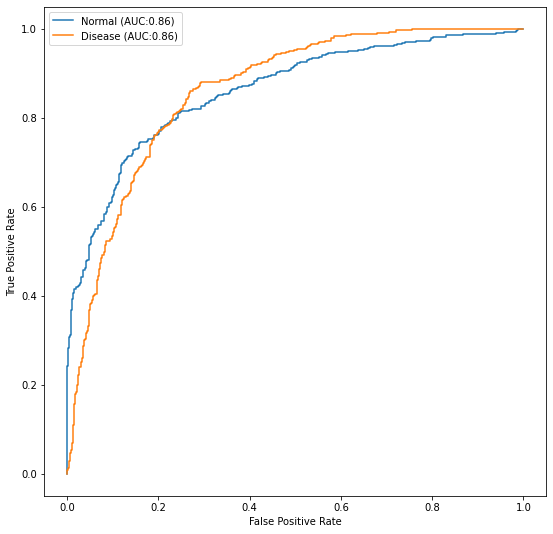

In [74]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_binary):
    fpr, tpr, thresholds = roc_curve(test_Y_binary[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [75]:
print('ROC auc score: {:.3f}'.format(roc_auc_score(test_Y_binary.astype(int), y_pred)))

ROC auc score: 0.859


#### train 11 layers

29089792/29084464 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

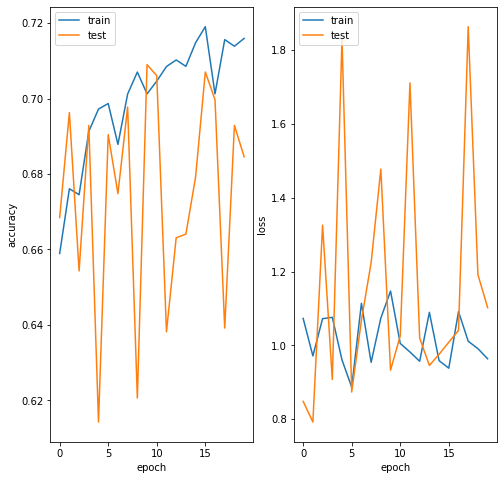

Epoch 1/50
287/287 [==============================] - ETA: 0s - loss: 1.2270 - binary_accuracy: 0.7171 - auc: 0.7840
Epoch 00001: loss improved from inf to 1.22703, saving model to /content/gdrive/My Drive/w210_capstone/balance_age_model/model_7p2_retrain11Layers/model_7_retrain11Layers.h5
287/287 [==============================] - 254s 887ms/step - loss: 1.2270 - binary_accuracy: 0.7171 - auc: 0.7840 - val_loss: 1.4988 - val_binary_accuracy: 0.6826 - val_auc: 0.7312
Epoch 2/50
287/287 [==============================] - ETA: 0s - loss: 1.0719 - binary_accuracy: 0.7302 - auc: 0.8027
Epoch 00002: loss improved from 1.22703 to 1.07193, saving model to /content/gdrive/My Drive/w210_capstone/balance_age_model/model_7p2_retrain11Layers/model_7_retrain11Layers.h5
287/287 [==============================] - 255s 889ms/step - loss: 1.0719 - binary_accuracy: 0.7302 - auc: 0.8027 - val_loss: 1.5248 - val_binary_accuracy: 0.6885 - val_auc: 0.7337
Epoch 3/50
287/287 [==============================] 

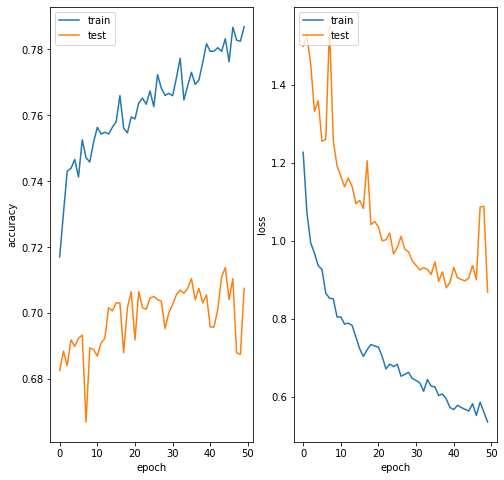

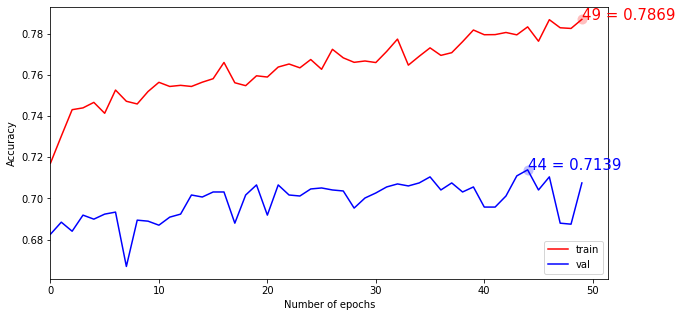

In [59]:
# https://keras.io/api/applications/ fine tune pretrained model

from tensorflow.keras.applications import DenseNet121
# pretrain_model_densenet121 = DenseNet121(weights = 'imagenet', include_top = False, input_shape=(img_size, img_size, 3))

# new_model, model_history = pretrainedNetwork(train_ds, valid_ds, pretrain_model_densenet121, class_weight_dict, 17, 50, optimizer_adam, map_dict)
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(len(labels_binary), activation="sigmoid")(x)
model = tf.keras.Model(base_model.input, output)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])
model.summary()
# this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])
logdir = "/content/gdrive/My Drive/w210_capstone/balance_age_model/model_7_retrain11Layers/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)    

# add checkpoint and model save
filepath = "/content/gdrive/My Drive/w210_capstone/balance_age_model/model_7_retrain11Layers/model_7_retrain11Layers.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [MetricsCheckpoint('logs'), checkpoint, tensorboard_callback]
# model.summary()
# train the model on the new data for a few epochs
history = model.fit(train_gen_binary,
              class_weight = class_weight_dict,
              validation_data=(test_X_binary, test_Y_binary),
              epochs=20, 
              callbacks = callbacks_list)


# plotkerasLearningCurve()
# plt.show()
plotLearningCurve(history)
plt.show()

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:-11]:
    layer.trainable=False
    
for layer in model.layers[-11:]:
    layer.trainable=True


# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['binary_accuracy', 'AUC'])
logdir = "/content/gdrive/My Drive/w210_capstone/balance_age_model/model_7p2_retrain11Layers/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)    

# add checkpoint and model save
filepath = "/content/gdrive/My Drive/w210_capstone/balance_age_model/model_7p2_retrain11Layers/model_7_retrain11Layers.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [MetricsCheckpoint('logs'), checkpoint, tensorboard_callback]

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history2 = model.fit(train_gen_binary,
              class_weight = class_weight_dict,
              validation_data=(test_X_binary, test_Y_binary),
              epochs=50, 
              callbacks = callbacks_list)
plotLearningCurve(history2)
plt.show()
plotkerasLearningCurve()
plt.show()


In [60]:
model = keras.models.load_model('/content/gdrive/My Drive/w210_capstone/balance_age_model/model_7p2_retrain11Layers/model_7_retrain11Layers.h5')


In [61]:
y_pred = model.predict(test_X_binary)

for label, p_count, t_count in zip(labels_binary,
                                     100 * np.mean(y_pred, 0),
                                     100 * np.mean(test_Y_binary, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (label, t_count, p_count))

Normal: actual: 55.47%, predicted: 52.41%
Disease: actual: 44.53%, predicted: 47.83%


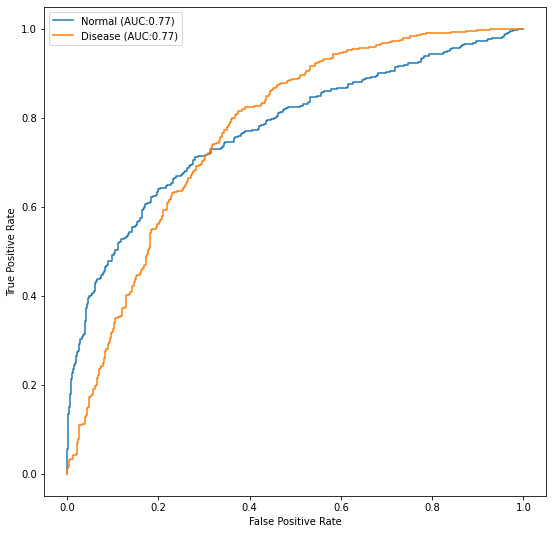

In [62]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_binary):
    fpr, tpr, thresholds = roc_curve(test_Y_binary[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [63]:
print('ROC auc score: {:.3f}'.format(roc_auc_score(test_Y_binary.astype(int), y_pred)))

ROC auc score: 0.772


# Debug COVID and Penumonia

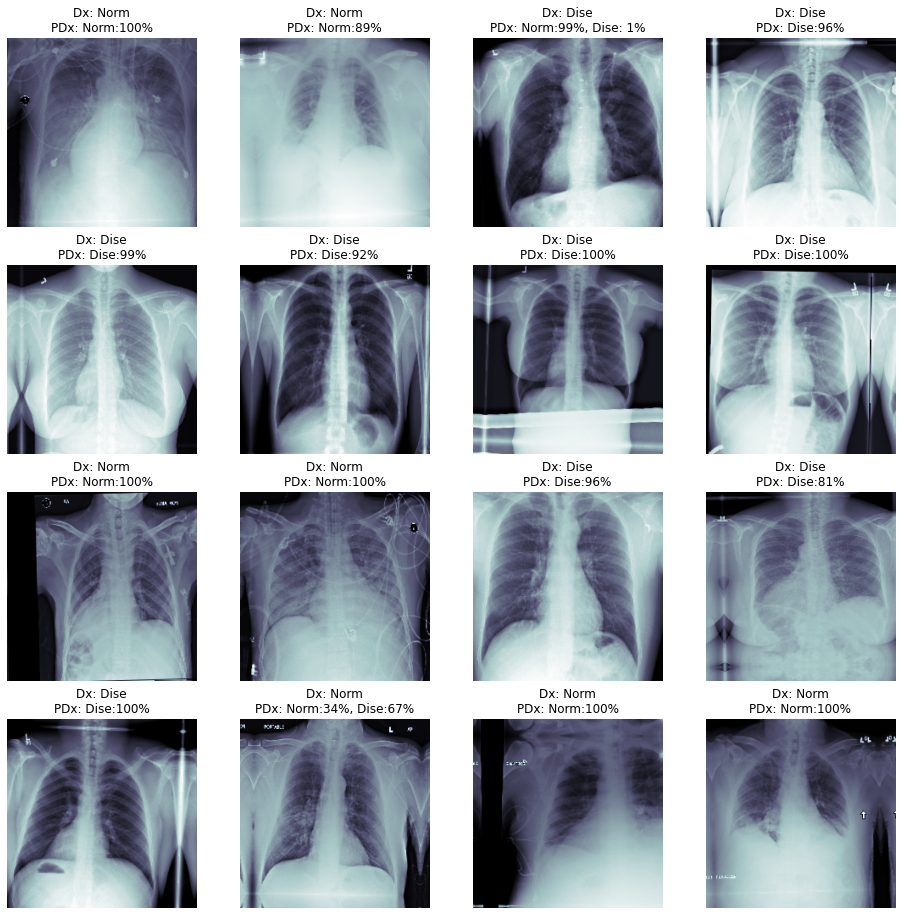

In [81]:
sickest_idx = np.argsort(np.sum(test_Y_binary, 1)<1)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X_binary[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:4] for n_class, n_score in zip(labels_binary, 
                                                                  test_Y_binary[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(labels_binary, 
                                                                  test_Y_binary[idx], y_pred[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
